# **Spaceship Titanic**

This document contains my workflow for the Spaceship Titanic prediction competition hosted by Kaggle.

## **Package and Data Loading**

In [2]:
## base packages
import pandas as pd
import statistics as stat
import numpy as np

## preprocessing
from sklearn.preprocessing import StandardScaler

## models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

## model evaluation
from sklearn.model_selection import cross_val_score

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
## return shape of training dataset
train.shape

(8693, 14)

In [5]:
## return shape of test dataset
test.shape

(4277, 13)

We will combine the training and testing datasets for joint preprocessing. 

In [6]:
## extract outcome variable
y = train['Transported']

## assign training indicator to training and testing sets
train['train'] = 'yes'
test['train'] = 'no'

## combine training and testing datasets
data = pd.concat([train.drop(columns = 'Transported'), test], axis = 0)

## check shape to make sure concatenation was successful
data.shape

(12970, 14)

## **EDA**

Let's start by visualizing the distributions of our variables. 

array([[<AxesSubplot: title={'center': 'Age'}>,
        <AxesSubplot: title={'center': 'RoomService'}>],
       [<AxesSubplot: title={'center': 'FoodCourt'}>,
        <AxesSubplot: title={'center': 'ShoppingMall'}>],
       [<AxesSubplot: title={'center': 'Spa'}>,
        <AxesSubplot: title={'center': 'VRDeck'}>]], dtype=object)

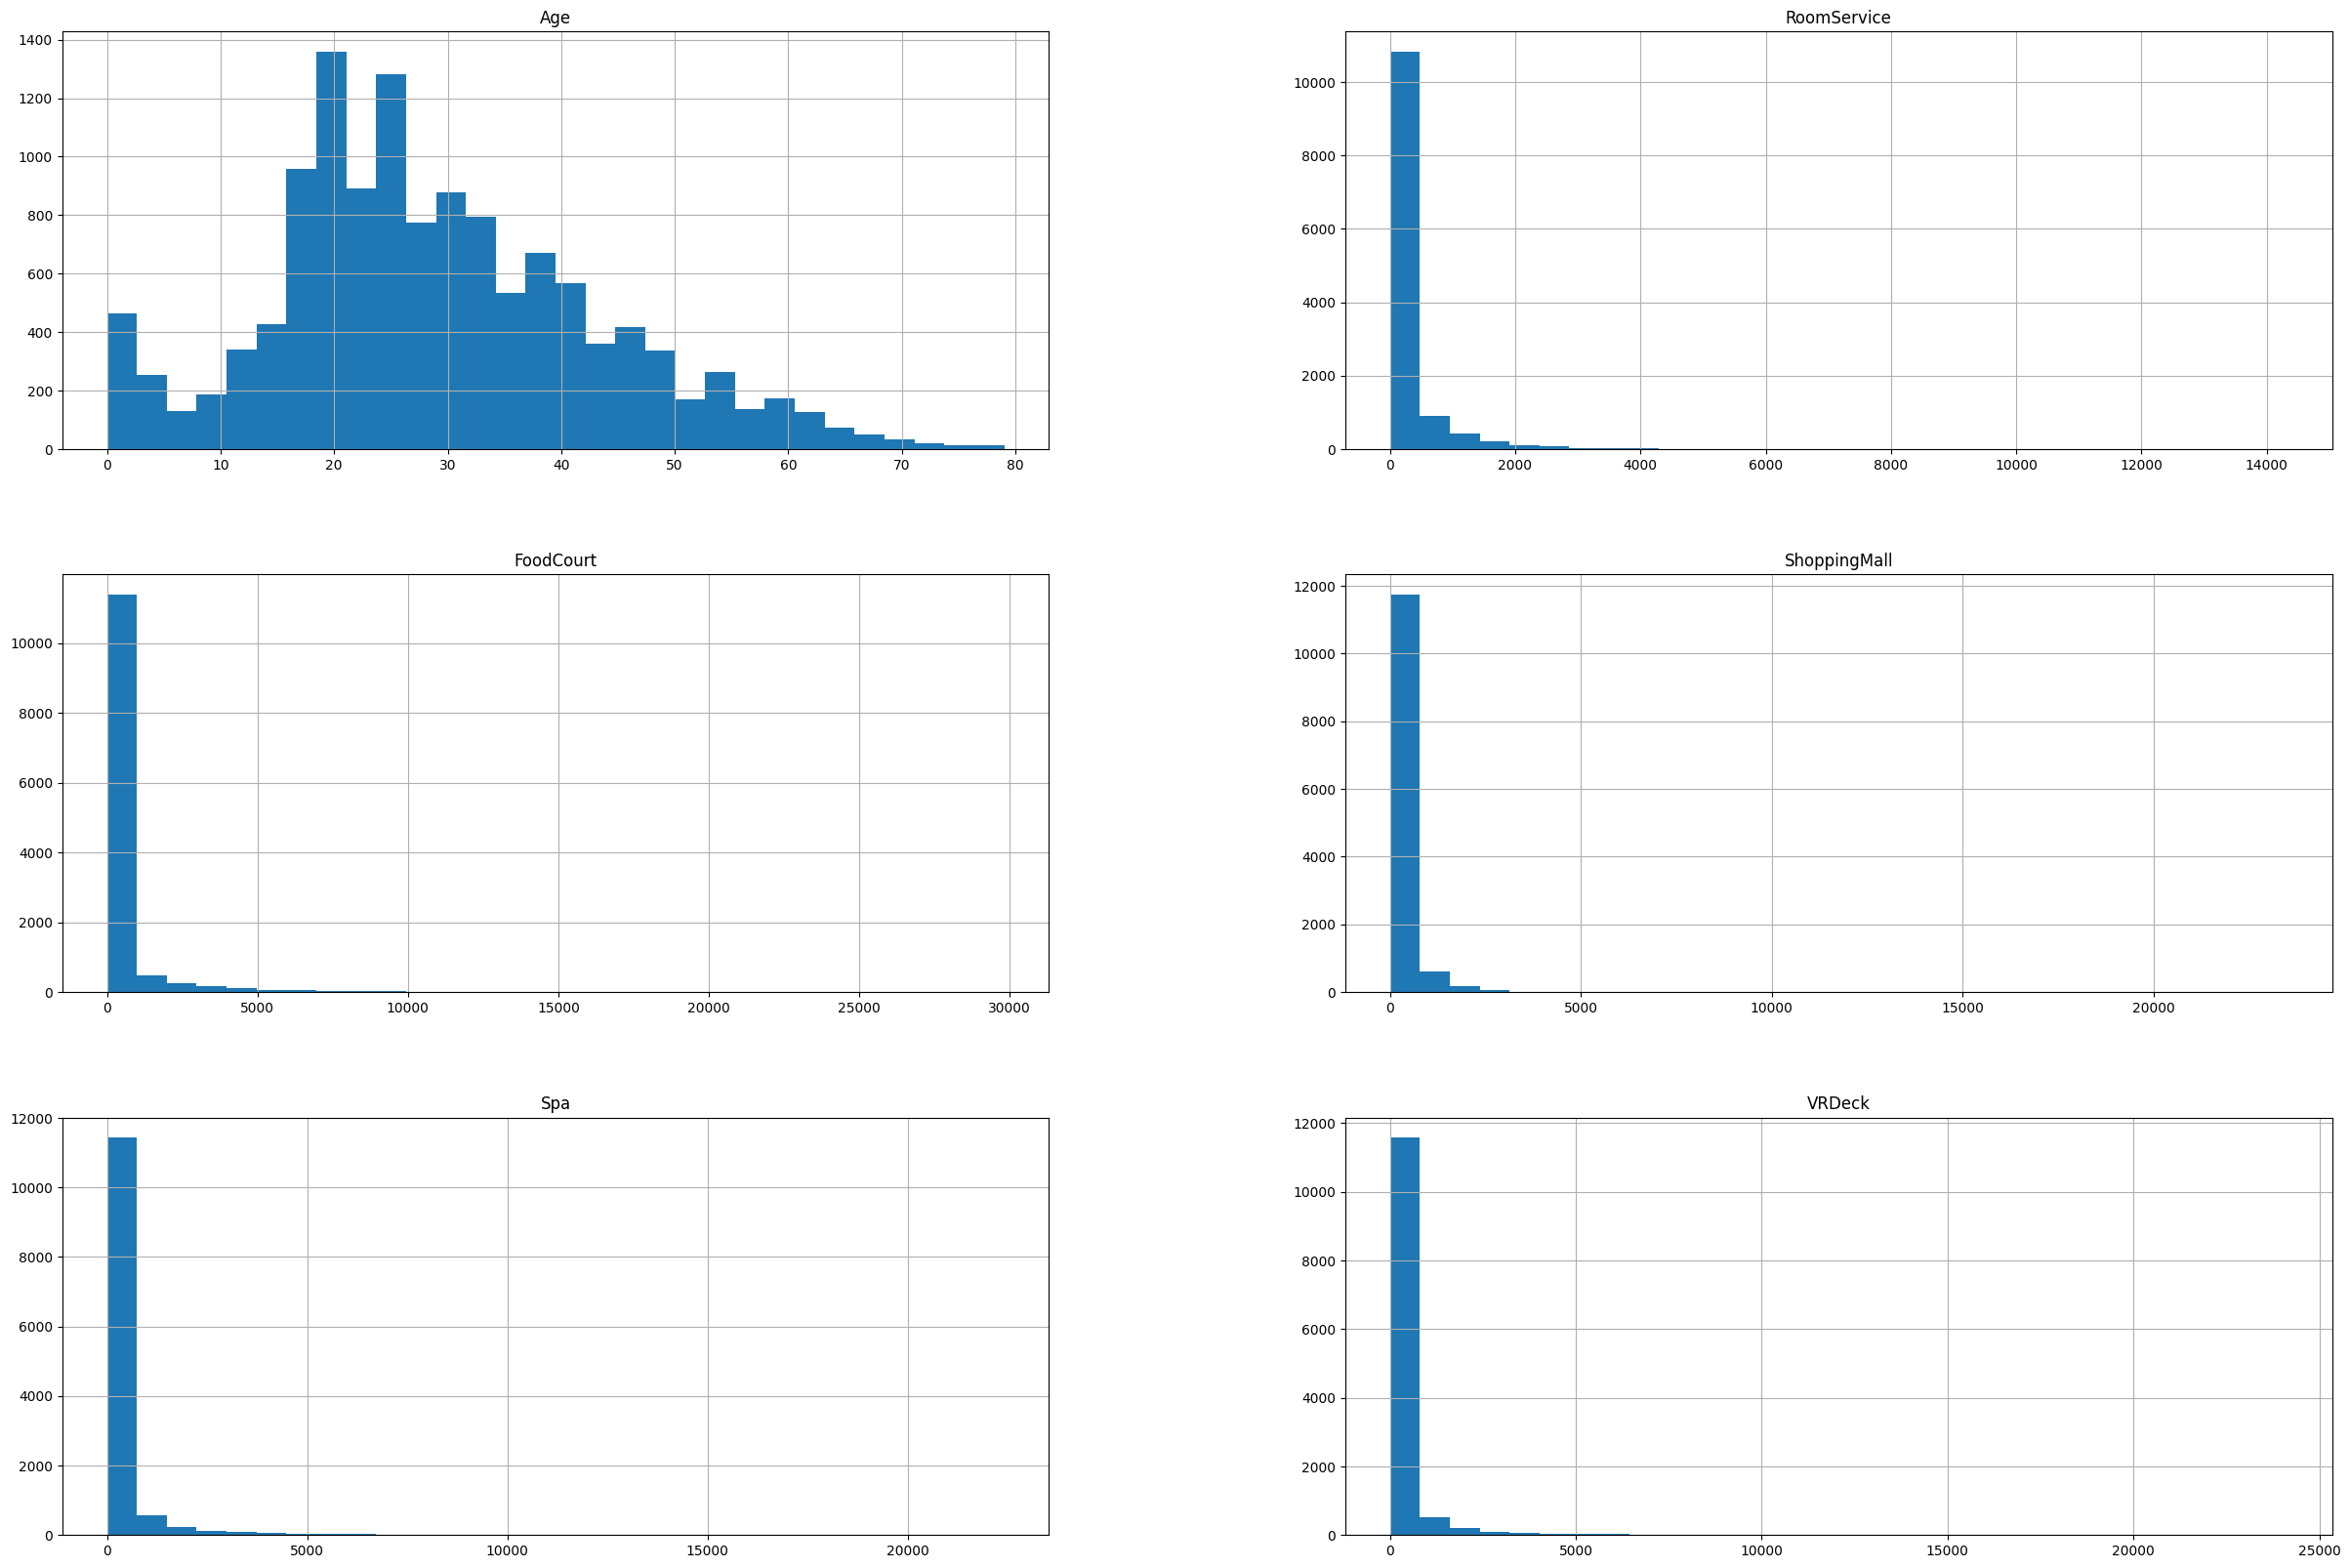

In [7]:
data.hist(bins = 30, figsize = (30, 20))

Looks like we might have some outliers to deal with for the amenity variables. Additionally, none of the continuous variables appear to be normal - since many machine learning algorithms tend to perform better with normally distributed inputs, we will consider log transforming our continuous predictors. 

Next, let's take a look at our missing values. 

In [8]:
na_prop = data.isna().sum() / len(data)

na_prop.sort_values(ascending = False)[na_prop > 0]

CryoSleep       0.023901
ShoppingMall    0.023593
Cabin           0.023053
VIP             0.022822
Name            0.022668
FoodCourt       0.022282
HomePlanet      0.022205
Spa             0.021897
Destination     0.021126
Age             0.020817
VRDeck          0.020663
RoomService     0.020278
dtype: float64

Looks like we don't have too many missing values to deal with! We will perform simple median/mode imputation to fill these values, depending on whether the given variable is continuous or categorical. 

## **Data Preprocessing**

First, let's fill in our missing values. We will have to exclude PassengerId, Name, and Cabin from our imputation strategy since we cannot use the median or mode to estimate these values. 

In [9]:
## simple helper function for missing value cleaning
def clean_missing_values(df):

    categorical_col = list(df.select_dtypes(exclude = 'number').columns.values)
    numeric_col = list(df.select_dtypes(include = 'number').columns.values)

    for col in categorical_col:
        data[col].fillna(value = stat.mode(data[col]), inplace = True)

    for col in numeric_col:
        data[col].fillna(value = data[col].median(), inplace = True)

In [10]:
## exclude name, cabin
exclude_from_imputation = data[['PassengerId', 'Name', 'Cabin']]
data.drop(columns = ['PassengerId', 'Name', 'Cabin'], inplace = True)

## clean missing values
clean_missing_values(data)

## rejoin name, cabin
data = pd.concat([data, exclude_from_imputation], axis = 1)

## check missing values
na_prop = data.isna().sum() / len(data)
na_prop.sort_values(ascending = False)[na_prop > 0]

Cabin    0.023053
Name     0.022668
dtype: float64

We should also scale our continuous variables to prepare them for machine learning algorithms.

array([[<AxesSubplot: title={'center': 'Age'}>,
        <AxesSubplot: title={'center': 'RoomService'}>],
       [<AxesSubplot: title={'center': 'FoodCourt'}>,
        <AxesSubplot: title={'center': 'ShoppingMall'}>],
       [<AxesSubplot: title={'center': 'Spa'}>,
        <AxesSubplot: title={'center': 'VRDeck'}>]], dtype=object)

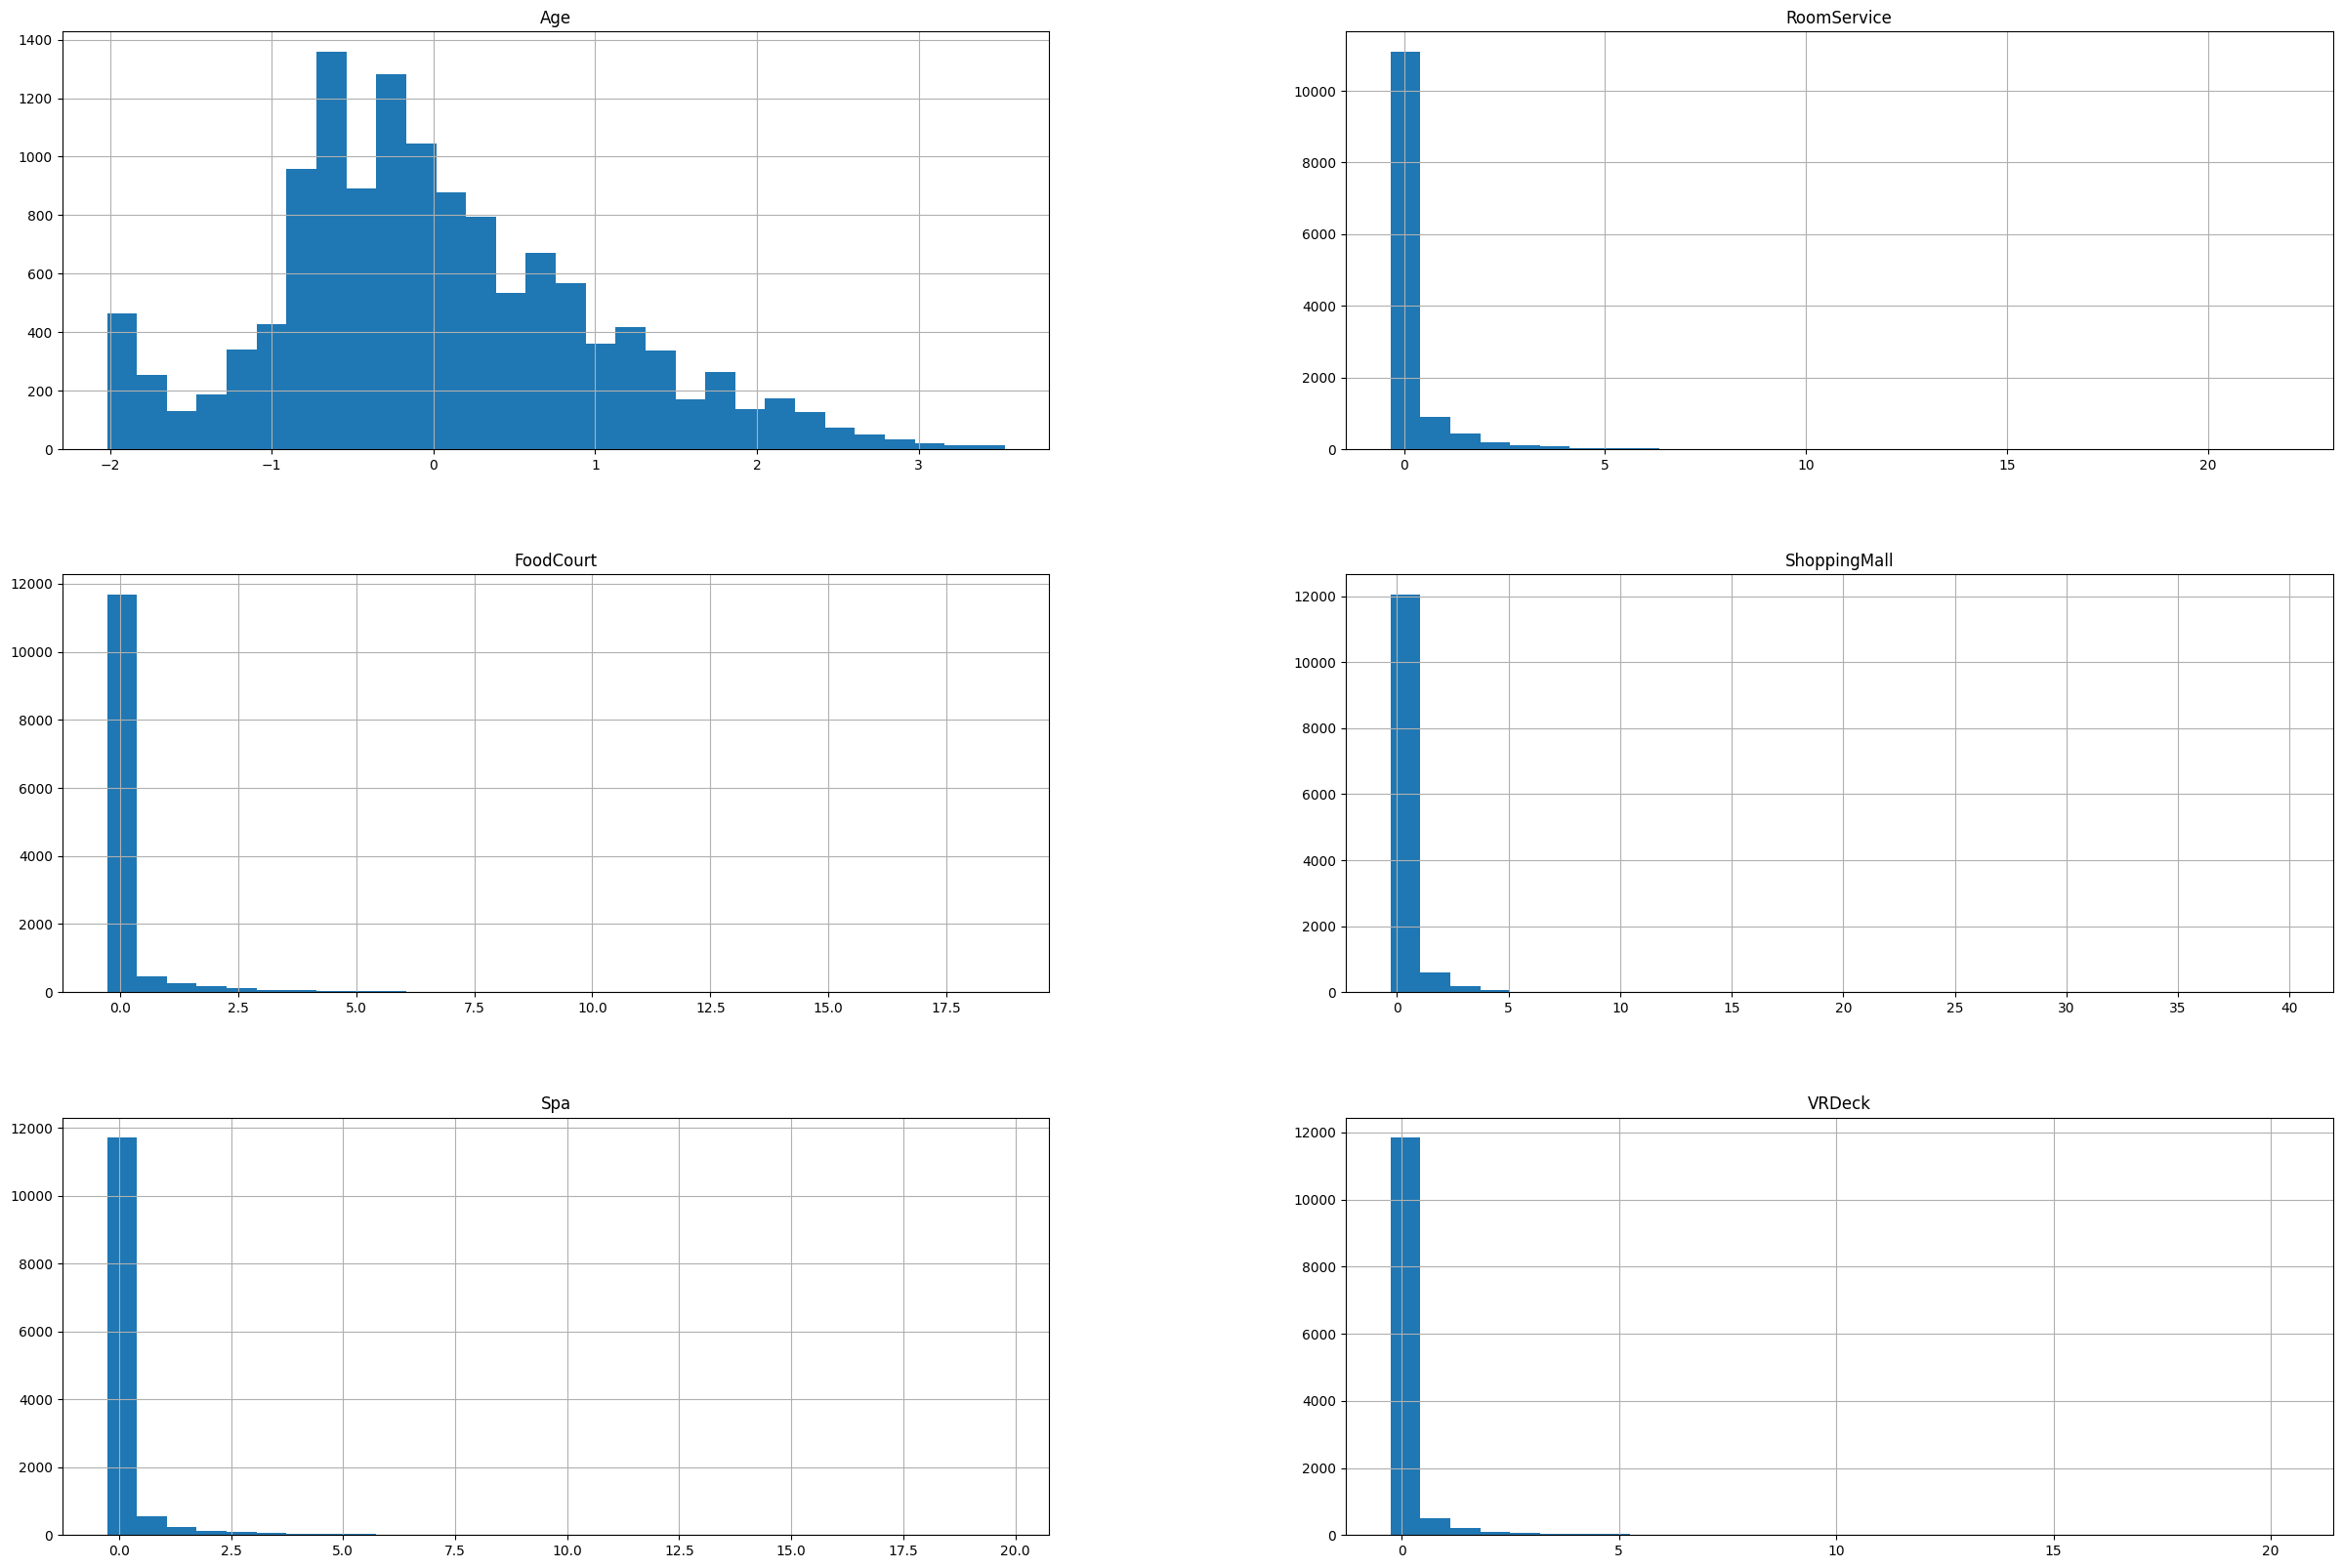

In [11]:
## define continuous columns
numeric_col = list(data.select_dtypes(include = 'number').columns.values)

## initialize scaler
scaler = StandardScaler()

## scale data
data[numeric_col] = scaler.fit_transform(data[numeric_col])

## visualize results
data.hist(bins = 30, figsize = (30, 20))

Next, let's do some feature selection. In more advanced notebooks, we might consider feature engineering using seemingly "uninformative" variables such as Name and Cabin. Here, we will just drop these variables. 

In [12]:
data.drop(columns = ['Name', 'Cabin'], inplace = True)

Let's also one-hot encode our categorical variables to prepare them for modeling. 

In [13]:
## define categorical columns
categorical_col = list(data.select_dtypes(exclude = 'number').columns.values)
categorical_col.remove('PassengerId')
categorical_col.remove('train')

## get dummy variables
data = pd.get_dummies(data, columns = categorical_col, drop_first = True)

Finally, split the data back into training and testing sets. 

In [14]:
## training set
X = data[data['train'] == 'yes'].drop(columns = ['train', 'PassengerId'])
X.shape

(8693, 12)

In [15]:
## testing set
test = data[data['train'] == 'no'].drop(columns = 'train')
test.shape

(4277, 13)

## **Predictive Modeling**

In this section, we will fit a series of models and assess them via cross-validated accuracy. The final model will combine all of the previous models using the stacking ensemble method. 

### Logistic Regression

In [16]:
## initialize and fit model
lr = LogisticRegression()
lr.fit(X, y)

## evaluate using cross validation
lr_acc = cross_val_score(lr, X, y, cv = 5).mean()
print(f'The average five-fold cross-validated accuracy for the logistic regression model is: {lr_acc}')

The average five-fold cross-validated accuracy for the logistic regression model is: 0.7856902271122578


### Random Forest

In [38]:
## initialize and fit model
rf = RandomForestClassifier()
rf.fit(X, y)

## evaluate using cross validation
rf_acc = cross_val_score(rf, X, y, cv = 5).mean()
print(f'The average five-fold cross-validated accuracy for the random forest classifier is: {rf_acc}')

The average five-fold cross-validated accuracy for the random forest classifier is: 0.7977703678754042


### XGBoost

In [27]:
## initialize and fit model
xgb = XGBClassifier()
xgb.fit(X, y)

## evaluate using cross validation
xgb_acc = cross_val_score(xgb, X, y, cv = 5).mean()
print(f'The average five-fold cross-validated accuracy for the XGBoost classifier is: {xgb_acc}')

The average five-fold cross-validated accuracy for the XGBoost classifier is: 0.7955855348529737


### Gradient Boosting

In [43]:
## initialize and fit model
gb = GradientBoostingClassifier()
gb.fit(X, y)

## evaluate using cross validation
gb_acc = cross_val_score(gb, X, y, cv = 5).mean()
print(f'The average five-fold cross-validated accuracy for the gradient boosting classifier is: {gb_acc}')

The average five-fold cross-validated accuracy for the gradient boosting classifier is: 0.7970812425431333


### Support Vector Machine

In [44]:
## initialize and fit model
sv = SVC()
sv.fit(X, y)

## evaluate using cross validation
sv_acc = cross_val_score(sv, X, y, cv = 5).mean()
print(f'The average five-fold cross-validated accuracy for the support vector machine classifier is: {sv_acc}')

The average five-fold cross-validated accuracy for the support vector machine classifier is: 0.7892582075991719


### Stacking

In [48]:
## initialize and fit model
models = [('lr', lr), ('rf', rf), ('gb', gb), ('xgb', xgb), ('sv', sv)]
stack = StackingClassifier(estimators = models)
stack.fit(X, y)

## evaluate using cross validation
stack_acc = cross_val_score(stack, X, y, cv = 5).mean()
print(f'The average five-fold cross-validated accuracy for the stacking classifier is: {stack_acc}')

The average five-fold cross-validated accuracy for the stacking classifier is: 0.7997265071059847


## **Predictions and Submission**

In [49]:
pred = stack.predict(test.drop(columns = "PassengerId"))

pred = ["False" if row == 0 else "True" for row in pred.tolist()]

submission = pd.DataFrame({"PassengerId": test["PassengerId"], "Transported": pred})

In [50]:
submission.to_csv("submission.csv", index=False)